# LunarLander-v2 with Deep Q-Network (DQN) and Double DQN
---
More about the environment LunarLander-v2 is found at https://gym.openai.com/envs/LunarLander-v2/

The RL algorithms implemented here are inspired by the following paper:

Mnih, V.; Kavukcuoglu, K.; Silver, D.; Rusu, A. A.; Veness, J.; Bellemare, M. G.; Graves, A.; Riedmiller, M.; Fidjeland, A. K.; Ostrovski, G.; Petersen, S.; Beattie, C.; Sadik, A.; Antonoglou, I.; King, H.; Kumaran, D.; Wierstra, D.; Legg, S. & Hassabis, D. (2015), 'Human-level control through deep reinforcement learning', Nature 518 (7540), 529--533.

Hasselt, H.; Guez, A.; Silver, D. (2016), 'Deep reinforcement learning with double Q-Learning', In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence (AAAI'16), AAAI Press 2094-2100.

We save about 50+ episodes of training time using Double DQN, given that all hyperparameters are set the same between DQN and Double DQN. 

In [1]:
import gym
!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for pyvirtualdisplay ... done
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Running setup.py bdist_wheel for EasyProcess ... done
  Stored in directory: /root/.cache/pip/wheels/41/22/19/af15ef6264c58b625a82641ed7483ad05e258fbd8925505227
Successfully built pyvirtualdisplay EasyProcess
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (8,)
Number of actions:  4


In [3]:
def dqn(agent, model_file, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), model_file)
            break
    return scores

## Deep Q-Learning Network (DQN)

Episode 100	Average Score: -213.66
Episode 200	Average Score: -155.45
Episode 300	Average Score: -70.014
Episode 400	Average Score: -60.03
Episode 500	Average Score: 69.730
Episode 600	Average Score: 140.68
Episode 700	Average Score: 159.01
Episode 800	Average Score: 188.09
Episode 900	Average Score: 192.18
Episode 958	Average Score: 201.47
Environment solved in 858 episodes!	Average Score: 201.47


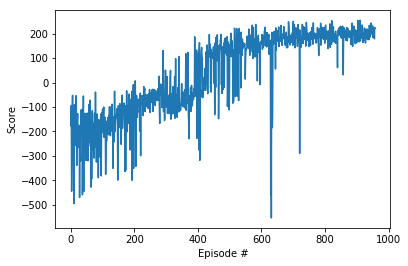

In [17]:
from dqn_agent import DqnAgent

dqn_agent = DqnAgent(state_size=8, action_size=4, seed=0, fc1_dim=64, fc2_dim=64)

scores = dqn(dqn_agent, 'checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

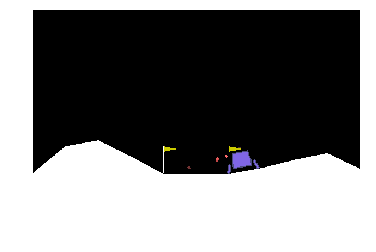

In [8]:
# load the weights from file
dqn_agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=lambda storage, loc: storage))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = dqn_agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

## Double Deep Q-Learning Network (Double DQN)

Episode 100	Average Score: -203.00
Episode 200	Average Score: -122.11
Episode 300	Average Score: -41.041
Episode 400	Average Score: 31.490
Episode 500	Average Score: 88.66
Episode 600	Average Score: 130.13
Episode 700	Average Score: 185.92
Episode 800	Average Score: 176.18
Episode 900	Average Score: 193.38
Episode 907	Average Score: 202.21
Environment solved in 807 episodes!	Average Score: 202.21


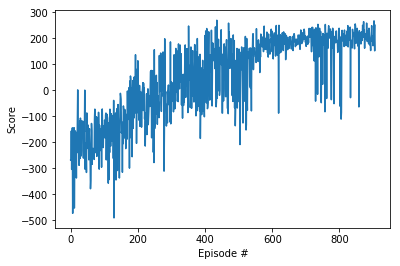

In [4]:
from double_dqn_agent import DoubleDqnAgent

TAU = 1e-3

ddqn_agent = DoubleDqnAgent(state_size=8, action_size=4, seed=0, fc1_size=64, fc2_size=64, tau=TAU)
scores = dqn(ddqn_agent, 'checkpoint_ddqn.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

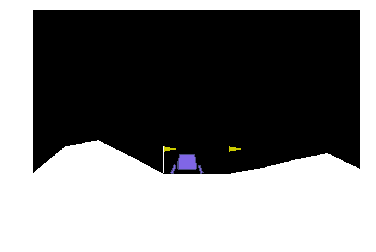

In [5]:
# load the weights from file
from double_dqn_agent import DoubleDqnAgent

TAU = 1e-3

ddqn_agent = DoubleDqnAgent(state_size=8, action_size=4, seed=0, fc1_size=64, fc2_size=64, tau=TAU)
ddqn_agent.qnetwork_local.load_state_dict(torch.load('checkpoint_ddqn.pth', map_location=lambda storage, loc: storage))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = ddqn_agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()